In [46]:
import os
from tqdm import tqdm
import shutil
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import joblib

In [10]:
import urllib.request

# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file

print("Download complete. Please check the checksums")

downloadingimages_01.tar.gz...
downloadingimages_02.tar.gz...
downloadingimages_03.tar.gz...
downloadingimages_04.tar.gz...
downloadingimages_05.tar.gz...
downloadingimages_06.tar.gz...
downloadingimages_07.tar.gz...
downloadingimages_08.tar.gz...
downloadingimages_09.tar.gz...
downloadingimages_10.tar.gz...
downloadingimages_11.tar.gz...
downloadingimages_12.tar.gz...
Download complete. Please check the checksums


In [4]:
base_dir = '../../input'
zips = os.listdir('.')
zips = [x for x in zips if x.endswith('tar.gz')]
for filename in tqdm(zips):
    shutil.unpack_archive(filename, base_dir)
os.rename('../../input/images', '../../input/nihchest')

100%|██████████| 12/12 [01:44<00:00,  8.73s/it]


# deduplicate

In [14]:
duplicates = pd.read_csv('duplicates.csv')
duplicates.head()
duplicates['original'] = duplicates['original'].apply(lambda x: '../../input/kaggle/train/'+x.split('/')[-1])
duplicates['dublicated'] = duplicates['dublicated'].apply(lambda x: '../../input/nihchest/'+x.split('/')[-1])

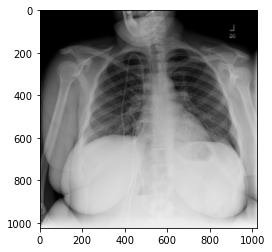

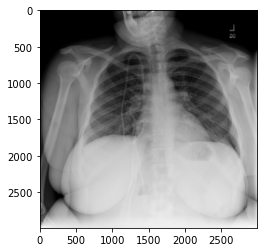

In [17]:
row = duplicates.loc[100]
plt.imshow(cv2.imread(row['dublicated']))
plt.show()
plt.imshow(cv2.imread(row['original']))

In [28]:
print(len(duplicates))
duplicates['dublicated'].nunique()

28729


28028

In [20]:
print(len(os.listdir('../../input/nihchest')))
for path in duplicates['dublicated'].unique():
    os.remove(path)
print(len(os.listdir('../../input/nihchest')))

111524
84092


In [33]:
train_dir = '../../input/kaggle/train'
test_dir = '../../input/kaggle/test'
target_dir = '../../input/nihchest'
for path in os.listdir(train_dir):
    shutil.copy(os.path.join(train_dir, path), os.path.join(target_dir, path))
for path in os.listdir(test_dir):
    shutil.copy(os.path.join(test_dir, path), os.path.join(target_dir, path))

In [48]:
def preprocess(path):

    label_cols = [
        'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
        'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
        'Swan Ganz Catheter Present'
    ]
    res = {}

    # image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    res['img'] = img

    # labels
    res['labels'] = np.zeros(11, dtype=np.float32)

    # masks
    height, width = img.shape[0], img.shape[1]
    res['masks'] = []
    res['tips'] = []
    res['annotated'] = 0
    res['mask_exist_index'] = []
    res['masks'] = np.array(res['masks'], dtype=np.int8)
    res['tips'] = np.array(res['tips'], dtype=np.int16)
    
    fname = path.split('/')[-1][:-3]+'.jl'
    joblib.dump(res, f'../../input/processed/nihchest/{fname}', compress=1)

folder = '../../input/nihchest'
paths = os.listdir(folder) 
paths = [os.path.join(folder, x) for x in paths]
len(paths)

117757

In [49]:
with Pool(64) as pool:
    list(tqdm(pool.imap_unordered(preprocess, paths), total=len(paths)))

100%|██████████| 117757/117757 [02:16<00:00, 862.29it/s]
